<a href="https://colab.research.google.com/github/jarussell/OReillyColab/blob/master/O'Reilly_ML_Engineer_Take_Home_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to Rank with XGBoost on MSLR-Web10K

This work is conducted as a take-home exam for a job search.

Solution by Jacob Russell

## Overview:
- Make a copy of this notebook.
- Download the dataset to the notebook (link in Step 2 comments)
- Preprocess and evaluate the dataset
- Build a **ranking** model
- Evaluate your ranking model using a metric of your choice
- Answer discussion questions
- Submit your notebook


## Notes

 

*   Throughout the notebook you should include notes explaining your choices and what you are doing. Your thought process is more important than the actual performance of your model.
*   Create as many cells as you want. The exisiting cells are just provided to provide some initial organization.
* You may use any choice of libraries or frameworks.
* If ranking models are new to you, consider starting here:<br>
  &nbsp;&nbsp;&nbsp;&nbsp;LTR Intro http://times.cs.uiuc.edu/course/598f14/l2r.pdf (overview/introduction to Learning to Rank - 2011)<br>
  &nbsp;&nbsp;&nbsp;&nbsp;TFR https://arxiv.org/abs/1812.00073 (a specific implementation/framework for Learning to Rank models - 2019)

# The Model

### 1) Imports

In [1]:
# Import dependencies here

#XGBoost uses pandas.Int64Index instead of pandas.Index
#these warnings show up almost everywhere so let's get rid of them
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import urllib.request #for downloading zip
import pathlib 
from zipfile import ZipFile
import hashlib #for security/verifying download

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
import scipy.stats as stats
from sklearn.model_selection import PredefinedSplit
import numpy as np

#This is a hack to work around an upstream bug
from joblib import parallel_backend

/home/blueblob/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/blueblob/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### 2) Download Dataset
The utility of a notebook that does not automatically acquire the data is not high. I have put a little bit of extra effort into making sure that the notebook should run as long as you:
`pip install -U pandas urllib xgboost sklearn matplotlib scipy`.

I apologize for how slow the notebook is. Firstly, the data is presented in 5* folds for Cross-Validation so we make a fold class to keep track of them.

\* More on the supposed 5-folds in the preprocessing section. 

In [2]:
# Download the dataset located at https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
# You can read about the features included in the dataset here: https://www.microsoft.com/en-us/research/project/mslr/

class Fold:
    """A simple representation of a fold for MSLR data.
    
    Data is stored all together and split with a method call when we need splits.
    """
    def __init__(self,data):
        self.data=data
        self.prune()
    
    def getXYQid(self):
        #copy so we don't lose data if called multiple times with pops
        x=self.data.copy()
            
        y=x.pop('rating')
        qid=x.pop('query_id')
        
        return x,y,qid
    
    def prune(self):
        #remove pointwise examples that cannot be computed with NDCG
        qids=self.data['query_id'].unique()
        bal_list=[]
        for qid in qids:
            qid_inds=self.data.loc[self.data['query_id'] == qid].index
        
            #drop examples with only a single class of rating because it is pointwise and cannot use nDCG
            if len(qid_inds) == 1:
                self.data.drop(qid_inds,inplace=True)

        self.data.reset_index(drop=True,inplace=True)
    
    def balance(self):
        """Balance classes in the training data by undersampling low ratings"""
        qids=self.data['query_id'].unique()

        bal_list=[]
        for qid in qids:
            df=self.data.loc[self.data['query_id'] == qid]
            
            uniq=df['rating'].value_counts().to_dict()
        
            #drop examples with only a single class of rating
            #because it cannot have a meaningful NDCG
            if len(uniq) == 1:
                continue
    
            n_samples=min(uniq.values())
        
            #We want to give leeway on dropping ratings 3 and 4 because there are so few of them
            #so we drop samples proportionally to the rating itself
            n_samples={k:min([v,n_samples+2*max(k-2,0)]) for k,v in uniq.items()}
            
            bal_list.extend([resample(df[df['rating']==k],n_samples=n_samples[k],random_state=42) for k in uniq.keys()])
                               
        self.data=pd.concat(bal_list,ignore_index=True)



We create a class for the dataset itself, that involves all of the code for downloading, verifying the hash, and converting the data into the formats that we need.

In [3]:
class MSLRData:
    def __init__(self,url='https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip',file='MSLR-WEB10K.zip',
                      basepath='data',md5sum='97c5d4e7c171e475c91d7031e4fd8e79'):
        self.folds=list()
        self.download(url,file,basepath,md5sum)
        self.load(basepath)
        self.preprocess()
        self.vali=self.folds.pop()
        self.test=self.folds.pop()
        
    def download(self,url,file,basepath,md5sum):
        #don't download a 1.2GiB file every time we run
        if not pathlib.Path(file).exists():
            print('Downloading 1.2GiB file.\nPlease be patient.')
            urllib.request.urlretrieve(url, file)
            print('Done.')
        hash=hashlib.md5(open(file,'rb').read()).hexdigest()
        
        #Don't extract a file from the internet that has an incorrect hash
        if not hash == md5sum:
            raise Exception(f'Checksums do not match!\n{hash} is supposed to be {md5sum}\nExiting.')
        
        #extract the data if we haven't previously done so
        if not pathlib.Path(basepath).exists():
            pathlib.Path(basepath).mkdir()
            with ZipFile(file, 'r') as zip:
                print('Extracting data.')
                zip.extractall(basepath)
                
    def getHeadings(self):
        #use all headings even though we may drop some.
        #This makes it easier to modify if we decide to change approaches
        #we also include an extra heading called garbage because of the way pd.readcsv handles the extra space
        return ['rating','query_id',
                'covered_query_term_number_body','covered_query_term_number_anchor','covered_query_term_number_title','covered_query_term_number_url','covered_query_term_number_whole_document',
                'covered_query_term_ratio_body','covered_query_term_ratio_anchor','covered_query_term_ratio_title','covered_query_term_ratio_url','covered_query_term_ratio_whole_document',
                'stream_length_body','stream_length_anchor','stream_length_title','stream_length_url','stream_length_whole_document',
                'idf_body','idf_anchor','idf_title','idf_url','idf_whole_document',
                'sum_of_term_frequency_body', 'sum_of_term_frequency_anchor', 'sum_of_term_frequency_title', 'sum_of_term_frequency_url', 'sum_of_term_frequency_whole_document',
                'min_of_term_frequency_body', 'min_of_term_frequency_anchor', 'min_of_term_frequency_title', 'min_of_term_frequency_url', 'min_of_term_frequency_whole_document',
                'max_of_term_frequency_body', 'max_of_term_frequency_anchor', 'max_of_term_frequency_title', 'max_of_term_frequency_url', 'max_of_term_frequency_whole_document',
                'mean_of_term_frequency_body', 'mean_of_term_frequency_anchor', 'mean_of_term_frequency_title', 'mean_of_term_frequency_url', 'mean_of_term_frequency_whole_document',
                'variance_of_term_frequency_body', 'variance_of_term_frequency_anchor', 'variance_of_term_frequency_title', 'variance_of_term_frequency_url', 'variance_of_term_frequency_whole_document',
                'sum_of_stream_length_normalized_term_frequency_body', 'sum_of_stream_length_normalized_term_frequency_anchor', 'sum_of_stream_length_normalized_term_frequency_title', 'sum_of_stream_length_normalized_term_frequency_url', 'sum_of_stream_length_normalized_term_frequency_whole_document',
                'min_of_stream_length_normalized_term_frequency_body', 'min_of_stream_length_normalized_term_frequency_anchor', 'min_of_stream_length_normalized_term_frequency_title', 'min_of_stream_length_normalized_term_frequency_url', 'min_of_stream_length_normalized_term_frequency_whole_document',
                'max_of_stream_length_normalized_term_frequency_body', 'max_of_stream_length_normalized_term_frequency_anchor', 'max_of_stream_length_normalized_term_frequency_title', 'max_of_stream_length_normalized_term_frequency_url', 'max_of_stream_length_normalized_term_frequency_whole_document',
                'mean_of_stream_length_normalized_term_frequency_body', 'mean_of_stream_length_normalized_term_frequency_anchor', 'mean_of_stream_length_normalized_term_frequency_title', 'mean_of_stream_length_normalized_term_frequency_url', 'mean_of_stream_length_normalized_term_frequency_whole_document',
                'variance_of_stream_length_normalized_term_frequency_body', 'variance_of_stream_length_normalized_term_frequency_anchor', 'variance_of_stream_length_normalized_term_frequency_title', 'variance_of_stream_length_normalized_term_frequency_url', 'variance_of_stream_length_normalized_term_frequency_whole_document',
                'sum_of_tf_idf_body', 'sum_of_tf_idf_anchor', 'sum_of_tf_idf_title', 'sum_of_tf_idf_url', 'sum_of_tf_idf_whole_document',
                'min_of_tf_idf_body', 'min_of_tf_idf_anchor', 'min_of_tf_idf_title', 'min_of_tf_idf_url', 'min_of_tf_idf_whole_document',
                'max_of_tf_idf_body', 'max_of_tf_idf_anchor', 'max_of_tf_idf_title', 'max_of_tf_idf_url', 'max_of_tf_idf_whole_document',
                'mean_of_tf_idf_body', 'mean_of_tf_idf_anchor', 'mean_of_tf_idf_title', 'mean_of_tf_idf_url', 'mean_of_tf_idf_whole_document',
                'variance_of_tf_idf_body', 'variance_of_tf_idf_anchor', 'variance_of_tf_idf_title', 'variance_of_tf_idf_url', 'variance_of_tf_idf_whole_document',
                'boolean_model_body', 'boolean_model_anchor', 'boolean_model_title', 'boolean_model_url', 'boolean_model_whole_document',
                'vector_space_model_body', 'vector_space_model_anchor', 'vector_space_model_title', 'vector_space_model_url', 'vector_space_model_whole_document',
                'bm25_body','bm25_anchor','bm25_title','bm25_url','bm25_whole_document',
                'lmir_abs_body', 'lmir_abs_anchor', 'lmir_abs_title', 'lmir_abs_url', 'lmir_abs_whole_document',
                'lmir_dir_body', 'lmir_dir_anchor', 'lmir_dir_title', 'lmir_dir_url', 'lmir_dir_whole_document',
                'lmir_jm_body', 'lmir_jm_anchor', 'lmir_jm_title', 'lmir_jm_url', 'lmir_jm_whole_document',
                'number_of_slash_in_url',
                'length_of_url',
                'inlink_number',
                'outlink_number',
                'page_rank',
                'site_rank',
                'quality_score',
                'quality_score_2',
                'query_url_click_count',
                'url_click_count',
                'url_dwell_time',
                'garbage'] #'garbage' is temporary and should be pruned
  
    def preprocess(self):
        for idx,fold in enumerate(self.folds):
            #remove 'qid:' from 'qid:1', etc
            df=fold.applymap(lambda x: x if type(x) is not str else x.split(":", 1)[-1])
                
            #set proper column headings
            df.columns=self.getHeadings()
                
            #remove extra column caused by extra whitespace
            df.drop(columns=['garbage'], inplace=True)
                
            #convert columns to the proper type
            for col in df.columns:
                try:
                    df=df.astype({col:int})
                except:
                    df=df.astype({col:float})
                        
            #XGBoost requires the query_id to be sorted ascending
            #sorting does not matter because only the relative ranking matters
            df.sort_values(by='query_id',ignore_index=True,inplace=True)
            self.folds[idx]=Fold(df)

           
    
    def load(self,basepath):
        #load all folds (file names are in the correct order: Fold1 ... Fold5)
        for path in pathlib.Path(basepath).glob('*'):
            try:
                #The data in train.txt files is literally the exact contents of 3 of the test.txt or vali.txt files
                fold=pd.DataFrame(pd.read_csv(f"{path}/test.txt", delimiter=" ",header=None))
                self.folds.append(fold)
            except:
                print(f'Skipping {path} because we could not load test.txt.')
                
    def _cvMerge(self):
        #merge training folds to one single array with a mask keeping track of where they came from
        x=pd.concat([fold.data for fold in self.folds],ignore_index=True)
        
        #generate a mask identifying which fold the data originally from
        mask=[]
        for i,l in enumerate([fold.data.shape[0] for fold in self.folds]):
            mask=mask+[i]*l
        
        #must be sorted by qid for XGBRanker
        x.sort_values(by='query_id',inplace=True)
        
        #modify the mask to get the post-sort positions
        mask=[mask[i] for i in x.index]
        
        x.reset_index(drop=True)
        y=x.pop('rating')
        qid=x.pop('query_id')
        
        return mask,x,y,qid
    
    def getCrossvalidationFolds(self):
        #Cross-validation requires collapsing all of the premade folds
        #to one set
        rets=[*self._cvMerge(),*self.vali.getXYQid(),*self.test.getXYQid()]
        #rets=rets+[*self._cvAlign(fType)]
        return rets

In [4]:
#actually load the data
mslr=MSLRData()

#print an overview of what the data looks like
display(mslr.folds[0].data.head())

,rating,query_id,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,length_of_url,inlink_number,outlink_number,page_rank,site_rank,quality_score,quality_score_2,query_url_click_count,url_click_count,url_dwell_time
0,2,13,2,0,2,1,2,1.0,0.0,1.0,...,35,1,0,266,25070,28,7,0,0,0.000000
1,1,13,2,0,2,0,2,1.0,0.0,1.0,...,35,60,2,24260,7615,7,72,0,4,41.700000
2,1,13,2,0,0,1,2,1.0,0.0,0.0,...,52,14,11,834,61229,5,4,0,3,14.000000
3,2,13,2,2,2,1,2,1.0,1.0,1.0,...,34,26,8,18142,9943,10,64,0,38,43.238095
4,1,13,2,0,1,0,2,1.0,0.0,0.5,...,23,85494,16,63137,34790,2,31,0,0,0.000000


### 3) Preprocess and evaluate the dataset
The dataset has a description at [its Microsoft site](https://www.microsoft.com/en-us/research/project/mslr/). It was split into 5 Folds where each fold uses three sets for training, one for validation, and one for testing.

This is an awkward setup that I suspect leads to some misleading results. If you use the functions intended for running crossfold validation in `sklearn` (such as `GridSearchCV`, `RandomizedSearchCV`, etc), the default `refit` parameter automatically retrains on the full training set. In this case, the full training set includes all of the values in the test and validation sets over all of the folds. The test set is not actually left out in training. unless you do not perform the refit. Additionally, this choice makes the dataset `5x` the size that it needs to be just to store the other fold information when it could have just stored sets $\{s_1,...,s_5\}$.

We did a little bit of preprocessing in the previous step to ensure that we had added the feature labels and removed an extra column caused by extra whitespace at the end of each line. See `MSLRData.preprocess` in the second code block.

As far as the data goes, it would be nice to know whether the labels are relatively uniformly distributed or whether we have imbalanced data.

,Fold1,Fold2,Fold3
rating,,,
0,124783,126450,126084
1,77896,78015,75962
2,32458,31875,30913
3,4450,4053,4361
4,1932,1594,1769


The proportions of each ranking from Fold 1 training data
{0: 0.5166591448291853, 1: 0.32252534997246596, 2: 0.1343910831031927, 3: 0.01842505144522791, 4: 0.007999370649928164}


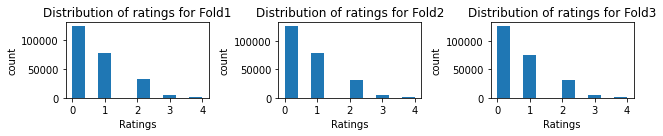

In [5]:
#show the distributions of the labels
def showTraining(data):
    fig, a = plt.subplots(1,len(data.folds),figsize=(3*len(data.folds),2))
    a = a.ravel()
    for idx,ax in enumerate(a):
        ax.hist(data.folds[idx].data['rating'])
        ax.set_title(f'Distribution of ratings for Fold{idx+1}')
        ax.set_xlabel('Ratings')
        ax.set_ylabel('count')
        ax.set_xticks(range(0,5))
    plt.tight_layout()
    
    
    fold_df=pd.DataFrame({f'Fold{idx+1}':fold.data[['rating']].value_counts() for idx,fold in enumerate(data.folds)})
    display(fold_df)
    
    print('The proportions of each ranking from Fold 1 training data')
    props=dict(zip(range(5),(data.folds[0].data[['rating']].value_counts()/float(data.folds[0].data.shape[0])).to_list()))
    print(props)

showTraining(mslr)

So it appears that we have an imbalanced dataset with labels that tend towards being irrelevant. There are `~71x` more samples of the totally irrelevant data than there are of the most relevant data. This is likely due to an implicit feedback mechanism where users did not click the link so it is assumed to be irrelevant. This informs us that we need to either reweight samples so that higher ratings are treated as more important or under(/over) sample some ratings. According to [Seiffert et al.](https://ieeexplore.ieee.org/document/4669722), resampling is more effective than reweighting. There are many choices for resampling and selecting an optimal choice is difficult. Because of time constraints, we will just elect to undersample the more common classes.

Since I am unable to find a resampling method that includes query id/group information, I will iterate and resample the groups, themselves. I will only resample the training data, not the testing or validation data because I still need to evaluate on the biases inherent to the data. Distributions across groups do not necessarily have all of the labels. Therefore getting a perfectly uniform distribution over the labels cannot happen over every group. Instead we're attempting to downsample so that over the average group we are closer to uniformly distributed.

We also have to drop single point groups. The NDCG ranking on a single point is not defined because an argument could very reasonably be made for either 0 or 1. It also would not be pairwise ranking, it would be pointwise.

,Fold1,Fold2,Fold3
rating,,,
0,9604,10049,10232
1,9601,10040,10224
2,8976,9309,9349
3,3864,3614,3672
4,1634,1474,1630


The proportions of each ranking from Fold 1 training data
{0: 0.28516286113008105, 1: 0.28507378485109414, 2: 0.26651622672882214, 3: 0.11473024733513465, 4: 0.04851687995486802}


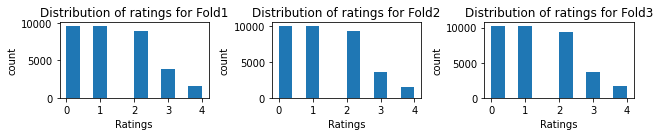

In [6]:
#Downsample the dataset to balance the classes
for fold in mslr.folds:
    fold.balance()

showTraining(mslr)

So the data is still somewhat imbalanced, but the imbalance has been reduced to only a `~6.5x` discrepancy between the least common and most common labels. The next step, time permitting, would be to oversample the relevant ratings (`3` and `4`). Reweighting could also still be used in order to boost how important groups containing samples with higher ratings are. Unfortunately, it appears that about `10%` of the most relevant points were contained as the only item in the group and had to be removed.

It can be hard to decide whether feature selection is part of modeling or preprocessing. In this case we selected to use boosted decision trees (XGBoost). This choice means that the generated trees will already have information relevant to feature selection after Cross-Validation so we will perform feature selection there.

### 4) Build ranking model

In [7]:
# Build ranking model

#ndcg_score expects an nd array of one hot encoded variables
#since we're wrapping it anyways, we might as well get some debug info if it fails
def train_score(y, y_pred):
    try:
        #data is paired so we need to sort parallel arrays by the correct order (y)
        y_l=list(y)
        order=sorted(range(len(y)), key=lambda k: y_l[k],reverse=True)
        y_true=[[y_l[i] for i in order]]
        y_score=[[y_pred[i] for i in order]]
        score = metrics.ndcg_score(y_true,y_score)
    except:
        raise Exception(f'Could not score\ny={y}\npred={y_pred}')
    return score

train_scorer=metrics.make_scorer(train_score, greater_is_better=True)

#Since I have an AMD GPU, I cannot use 'gpu_hist', this possibly hinders the accuracy of the model
#gpu_hist is required for `sampling_method='gradient_based'`
#so we have uniform sampling of training points instead of selecting the points with the most impact
model = xgb.XGBRanker(
    #tree_method='gpu_hist',
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    scoring = train_scorer,
    seed=42
    #eta=0.05
)

We selected the `XGBRanker` because boosted decision trees (such as lambdaMART) are SOTA on ranking tasks and `XGBoost` is efficient.

We decided to 5-Fold Cross-validation because the data was presented in 5 predefined folds. This selection was because we are expecting other people to use the folds in the same way. We would like to have our results as comparable as possible.

If the data was not presented in folds already, I would likely perform cross-validation differently. `sklearn.model_selection.StratifiedGroupKFold` does K-Fold Cross-Validation but attempts to sample so that the proportions of classes are balanced. This way the learned model is not heavily biased towards the lower ratings with such a class imbalance.

In [8]:
#Set data up for cross-validation
trainMask,trainX,trainY,trainQid,valiX,valiY,valiQid,testX,testY,testQid=mslr.getCrossvalidationFolds()
ps = PredefinedSplit(trainMask)#3-fold Cross-Validation

We tune our model using randomized grid search over our 3-fold cross-validation, withholding testing and validation data. We use only the training set for this. This way when we get results we can have an unbiased estimator of how well we did over the validation set and revise our model if we choose to do so. Selection of the parameter space to search can be difficult without having tuned it before. We looked for guides and found [one by XGBoost]((https://xgboost.readthedocs.io/en/stable/parameter.html)) and [one by Abhishek Thakur](https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur/). We use the image from his article below:

<img alt="Abhishek Thakur's recommended parameters" src="https://media-exp1.licdn.com/dms/image/C4E12AQFkhS6uoAoQUQ/article-inline_image-shrink_1000_1488/0/1520388368094?e=1653523200&v=beta&t=9HDJAwKEICZfuyC0geMozhAlTxliSRZvzQWNyHqjf3Q" width=400 height=400 />

In [9]:
#trainX,trainY,qid=data.folds[0].getXYQid('train')
#model.fit(trainX, trainY, qid=qid)

#params to search through for tuning

params = {'n_estimators': stats.randint(100, 800), #choose small values for timing sake
          'learning_rate': stats.uniform(0.01, 0.09),
          'subsample': stats.uniform(0.6, 0.4),
          'max_depth': [5, 6, 7], #choose small values for timing sake
          'colsample_bytree': stats.uniform(0.3, 0.2),
          'min_child_weight': [1, 3, 5, 7, 11, 15]} #large values can lead to early stopping


clf = RandomizedSearchCV(model,
                         param_distributions=params,
                         cv=ps,
                         n_iter=100,
                         #scoring = metrics.make_scorer(metrics.ndcg_score, greater_is_better=True),
                         scoring = train_scorer,
                         error_score=0,
                         verbose=3,
                         random_state=42,
                         n_jobs=-1)

clf2 = RandomizedSearchCV(model,
                         param_distributions=params,
                         cv=ps,
                         n_iter=100,
                         #scoring = metrics.make_scorer(metrics.ndcg_score, greater_is_better=True),
                         scoring = train_scorer,
                         error_score=0,
                         verbose=3,
                         random_state=42,
                         n_jobs=-1)


#This line is to work around an upstream bug related to frozen python objects in the default Loky backend
with parallel_backend("threading"):
    search=clf.fit(trainX,trainY,qid=trainQid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.952 total time=  23.0s
[CV 1/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.953 total time=  29.4s
[CV 2/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.952 total time=  29.5s
[CV 1/3] END colsample_bytree=0.3341048247374583, learning_rate=0.015854643368675155, max_depth=5, min_child_weight=7, n_estimators=113, subsample=0.9233589392465844;, score=0.948 total time=  14.9s
[CV 2/3] END colsample_bytree=0.3341048247374583, learning_rate=0.015854643368675155, max_depth=5, min_child_weight=7, n_estimators=113, subs

[CV 3/3] END colsample_bytree=0.45803510810624115, learning_rate=0.06453639773029102, max_depth=6, min_child_weight=3, n_estimators=140, subsample=0.9659838702175123;, score=0.952 total time=  22.6s
[CV 1/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.953 total time=  28.0s
[CV 2/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.952 total time=  27.3s
[CV 3/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.952 total time=  27.4s
[CV 1/3] END colsample_bytree=0.32818484499495254, learning_rate=0.08219772826786356, max_depth=5, min_child_weight=1, n_estimators=620, subsample=0.908897907718663;, score=0.955 total time= 1.4min


[CV 3/3] END colsample_bytree=0.353356202855057, learning_rate=0.09789534602493875, max_depth=6, min_child_weight=11, n_estimators=324, subsample=0.8537405378805455;, score=0.954 total time=  45.8s
[CV 2/3] END colsample_bytree=0.353356202855057, learning_rate=0.09789534602493875, max_depth=6, min_child_weight=11, n_estimators=324, subsample=0.8537405378805455;, score=0.954 total time=  46.4s
[CV 2/3] END colsample_bytree=0.41162040040346826, learning_rate=0.046345255395223675, max_depth=6, min_child_weight=1, n_estimators=541, subsample=0.9849789179768444;, score=0.954 total time= 1.3min
[CV 3/3] END colsample_bytree=0.41162040040346826, learning_rate=0.046345255395223675, max_depth=6, min_child_weight=1, n_estimators=541, subsample=0.9849789179768444;, score=0.954 total time= 1.3min
[CV 1/3] END colsample_bytree=0.316170665266543, learning_rate=0.0432689010455264, max_depth=5, min_child_weight=15, n_estimators=379, subsample=0.7881202537784153;, score=0.954 total time=  47.3s
[CV 2/3

[CV 3/3] END colsample_bytree=0.344853861892112, learning_rate=0.07409612992127822, max_depth=5, min_child_weight=15, n_estimators=376, subsample=0.6715290836885315;, score=0.953 total time=  51.2s
[CV 1/3] END colsample_bytree=0.4451911357740479, learning_rate=0.09073992339573193, max_depth=6, min_child_weight=1, n_estimators=727, subsample=0.6336559859980195;, score=0.954 total time= 1.8min
[CV 1/3] END colsample_bytree=0.4537108028612618, learning_rate=0.013924339457899037, max_depth=6, min_child_weight=11, n_estimators=145, subsample=0.9659457560881795;, score=0.950 total time=  22.5s
[CV 1/3] END colsample_bytree=0.3786195449333521, learning_rate=0.09028418996594019, max_depth=7, min_child_weight=5, n_estimators=325, subsample=0.7400313630778703;, score=0.955 total time=  57.1s
[CV 2/3] END colsample_bytree=0.4451911357740479, learning_rate=0.09073992339573193, max_depth=6, min_child_weight=1, n_estimators=727, subsample=0.6336559859980195;, score=0.953 total time= 1.8min
[CV 3/3]

[CV 2/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.951 total time= 1.4min
[CV 1/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.953 total time= 1.4min
[CV 3/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.952 total time= 1.4min
[CV 1/3] END colsample_bytree=0.4245780951638001, learning_rate=0.01768127184943912, max_depth=5, min_child_weight=7, n_estimators=449, subsample=0.8162540486440426;, score=0.952 total time=  53.2s
[CV 2/3] END colsample_bytree=0.4245780951638001, learning_rate=0.01768127184943912, max_depth=5, min_child_weight=7, n_estimators=449, subsample=0.8162540486440426;, score=0.951 total time=  53.6s
[CV 1/3

[CV 2/3] END colsample_bytree=0.4231702328779828, learning_rate=0.09495024441046813, max_depth=6, min_child_weight=1, n_estimators=259, subsample=0.9760920965699831;, score=0.954 total time=  39.2s
[CV 3/3] END colsample_bytree=0.4231702328779828, learning_rate=0.09495024441046813, max_depth=6, min_child_weight=1, n_estimators=259, subsample=0.9760920965699831;, score=0.953 total time=  38.6s
[CV 3/3] END colsample_bytree=0.3429178239416748, learning_rate=0.043953317490517826, max_depth=5, min_child_weight=5, n_estimators=134, subsample=0.7346216859554906;, score=0.950 total time=  17.4s
[CV 2/3] END colsample_bytree=0.37492252292529427, learning_rate=0.06632739241428127, max_depth=6, min_child_weight=1, n_estimators=424, subsample=0.8735855077592565;, score=0.954 total time= 1.0min
[CV 3/3] END colsample_bytree=0.37492252292529427, learning_rate=0.06632739241428127, max_depth=6, min_child_weight=1, n_estimators=424, subsample=0.8735855077592565;, score=0.954 total time= 1.0min
[CV 1/3

[CV 2/3] END colsample_bytree=0.493730388794827, learning_rate=0.0719227009157535, max_depth=6, min_child_weight=7, n_estimators=352, subsample=0.935392305505594;, score=0.954 total time=  52.8s
[CV 3/3] END colsample_bytree=0.493730388794827, learning_rate=0.0719227009157535, max_depth=6, min_child_weight=7, n_estimators=352, subsample=0.935392305505594;, score=0.954 total time=  52.4s
[CV 3/3] END colsample_bytree=0.31834082945169623, learning_rate=0.0642196833311007, max_depth=7, min_child_weight=11, n_estimators=583, subsample=0.9784778171526761;, score=0.954 total time= 1.7min
[CV 2/3] END colsample_bytree=0.31834082945169623, learning_rate=0.0642196833311007, max_depth=7, min_child_weight=11, n_estimators=583, subsample=0.9784778171526761;, score=0.954 total time= 1.7min
[CV 1/3] END colsample_bytree=0.31834082945169623, learning_rate=0.0642196833311007, max_depth=7, min_child_weight=11, n_estimators=583, subsample=0.9784778171526761;, score=0.955 total time= 1.7min
[CV 1/3] END 

[CV 2/3] END colsample_bytree=0.37765367679797446, learning_rate=0.030645527113445467, max_depth=5, min_child_weight=1, n_estimators=601, subsample=0.6129263804438602;, score=0.953 total time=  53.7s
[CV 3/3] END colsample_bytree=0.37765367679797446, learning_rate=0.030645527113445467, max_depth=5, min_child_weight=1, n_estimators=601, subsample=0.6129263804438602;, score=0.953 total time=  52.0s
[CV 1/3] END colsample_bytree=0.35595270143378915, learning_rate=0.047008604878496764, max_depth=5, min_child_weight=7, n_estimators=657, subsample=0.6304801518396652;, score=0.955 total time=  51.8s
[CV 2/3] END colsample_bytree=0.35595270143378915, learning_rate=0.047008604878496764, max_depth=5, min_child_weight=7, n_estimators=657, subsample=0.6304801518396652;, score=0.954 total time=  29.2s
[CV 3/3] END colsample_bytree=0.35595270143378915, learning_rate=0.047008604878496764, max_depth=5, min_child_weight=7, n_estimators=657, subsample=0.6304801518396652;, score=0.954 total time=  28.9s


We create a helper function for predicting and returning the results that we want back from the predictions in order to make it managable. We will be doing predictions to verify our model before and after feature selection and then again on the test set.

In [10]:
#ndcg_score expects an nd array of one hot encoded variables
#since we're wrapping it anyways, we might as well get some debug info if it fails
def eval_score(y, y_pred):
    try:
        #data is paired so we need to sort parallel arrays by the correct order (y)
        y_l=list(y)
        order=sorted(range(len(y)), key=lambda k: y_l[k],reverse=True)
        y_true=[[y_l[i] for i in order]]
        y_score=[[y_pred[i] for i in order]]
        score = metrics.ndcg_score(y_true,y_score)
        
        #we want multiple scores for 
        scores = [metrics.ndcg_score(y_true,y_score)]
        scores.extend([metrics.ndcg_score(y_true,y_score,k=k) for k in range(1,11)])
    except:
        raise Exception(f'Could not score\ny={y}\npred={y_pred}')
    return scores


def predict_and_eval(model,xdf,y,qid,model_name):
    #evaluate and put results in a dataframe
    preds=model.predict(xdf)
    
    df=pd.DataFrame({'pred': preds, 'rating': y, 'query_id': qid})
    
    #df=pd.concat([pd.DataFrame(preds),pd.DataFrame(y),pd.DataFrame(qid)],axis=1,ignore_index=True)
    #df.columns=['pred','rating','query_id']
    df.sort_values(['query_id', 'rating'], ascending=[True, False],inplace=True,ignore_index=True)
    
    unique_qids=df['query_id'].unique()
    scores=np.zeros(shape=(len(unique_qids),11)) 
    
    for idx,qid in enumerate(unique_qids):
        ratings=df.loc[df['query_id'] == qid]['rating'].to_list()
        predictions=df.loc[df['query_id'] == qid]['pred'].to_list()

        #compute per-group metrics
        scores[idx]=eval_score(ratings,predictions)
    
    cols=['model_name','NDCG']+[f'NDCG@{k}' for k in range(1,11)]
    vals=[[model_name]+scores.mean(axis=0).tolist()]
    
    res=pd.DataFrame(vals,columns=cols)
    #res=None
        
    return res

We have neglected feature selection to this point in favor of seeing how well the model fits without any selection. This way we can see what the model, itself, considered important on a variety of metrics. Eventually, we also want to do a qualitative analysis of whether the features that we found important are similar to features that others would find important on the same problem. We use a weighted average over all the metrics that the model provides for us (total gain, gain, weight, total cover, and cover). The gain and weight metrics are sort of the most important, but they need to be traded off with the cover metrics if we want the trees from our next training to behave similarly. The cover metrics define how many of the trees relied on each feature for the final model.

We could have used `RandomizedSearchCV` to perform feature selection for us, but the point is to illustrate that we know how to do it.

The model dropped 2 features:
	boolean_model_anchor
	boolean_model_url


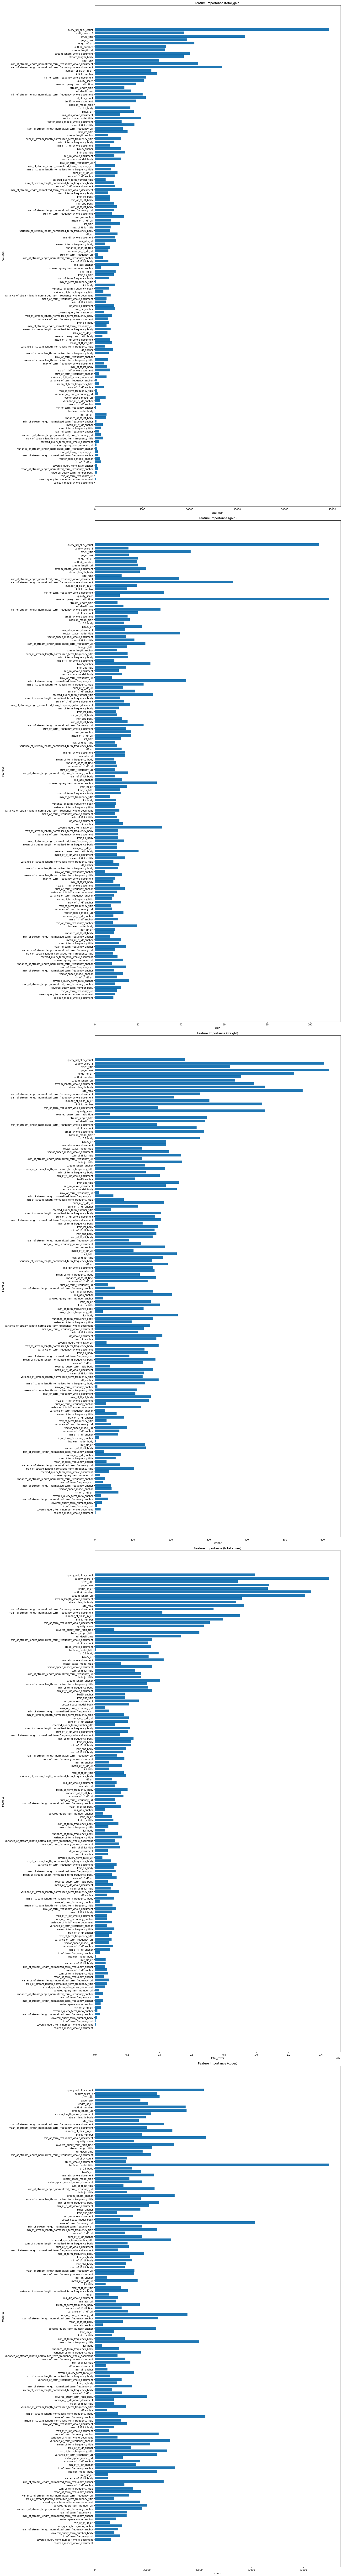

In [11]:
#Get a graphical display of metrics for the features
def showFeats(model):
    ftype=['total_gain','gain','weight','total_cover','cover']
    fnames=set(model.get_booster().feature_names)
    #fig, a = plt.subplots(len(ftype),1,figsize=(200,20))
    fig, a = plt.subplots(len(ftype),1,figsize=(20,150))
    a = a.ravel()
    
    #find features dropped by model
    missing=fnames.difference(fnames.intersection(model.get_booster().get_score(importance_type='gain').keys()))
    
    #ignore dropped features
    fnames=fnames.difference(missing)
    
    #sort by equally weighted average of important features over normalized metrics
    normed_sums={fname:0.0 for fname in fnames}
    for ft in ftype:
        max_val=float(max([val for val in model.get_booster().get_score(importance_type=ft).values()]))
        for k,v in model.get_booster().get_score(importance_type=ft).items():
            normed_sums[k]=normed_sums[k]+v/max_val
    normed_sums=dict(sorted(normed_sums.items(),key=lambda x: -x[1]))
        
    
    for idx,ax in enumerate(a):
        importance=model.get_booster().get_score(importance_type=ftype[idx])
        importance=[importance[name] for name in normed_sums.keys()]
        y_pos=np.arange(len(normed_sums))
        ax.barh(y_pos, importance)
        ax.set_title(f'Feature Importance ({ftype[idx]})')
        ax.set_xlabel(f'{ftype[idx]}')
        ax.set_ylabel('Features')
        ax.set_yticks(y_pos, labels=normed_sums.keys())
        ax.invert_yaxis()  # labels read top-to-bottom
        
    plt.tight_layout()
    if len(missing)>0:
        print(f'The model dropped {len(missing)} features:')
        for feat in missing:
            print(f'\t{feat}')
    return normed_sums

normed_sums=showFeats(search.best_estimator_)

I suggest right-clicking the image above and opening in a new tab where it can be zoomed out or in. Zooming out, you can see roughly the same pattern across almost all of the metrics because we sorted by the equal weighted average. The hard part is picking the cut-off point for the features. Note that the boolean features are hard to consider because they partition the trees but do not actually change the gain that much. They impact the cover so it may be worth considering them separately. The gaps in the non-cover metrics caused by the booleans serve as a good indicator of approximate relative distances from the top if you are zoomed all the way out.

We ran our model with Cross-validation and now we want to know whether the results are decent on our validation set to determine whether we need to re-train. Since we didn't use the validation set for training, it should give us unbiased estimates that we would expect to be similar to estimates on the test set. If we can sacrifice a small amount of accuracy in order to generalize better to the validation/testing set, we definitely want to do so.

We picked our cutoff at `min_of_stream_length_normalized_term_frequency_title` because it seemed to have the sharpest decline in features after it across all metrics. So we dropped all features below this threshold.

In [12]:
#get rid of the columns that we do not need
def dropcols(normed_sums,df,key):
    ind=len(normed_sums)
    
    if isinstance(key,int):
        ind=min(key,ind)
        
    elif key in df.columns:
        ind=list(normed_sums.keys()).index(key)
        
    if ind+1<len(normed_sums):
        drops=list(normed_sums.keys())[ind+1:]
        num_feats_reduced=ind+1
        print(f'selected {num_feats_reduced} features out of {len(mslr.getHeadings())-3}')
        return df.drop(drops,axis=1)
    
#selected_feat='min_of_stream_length_normalized_term_frequency_title'


selected_feat=30
#15 yielded vali ndcg=0.75, vali ndcg@10=0.53
#40 yielded vali ndcg=0.76, vali ndcg@10=0.54
    
cv_trainX=dropcols(normed_sums,trainX,selected_feat)
print(cv_trainX.shape[1])

with parallel_backend("threading"):
    search2=clf2.fit(cv_trainX,trainY,qid=trainQid)

selected 31 features out of 136
33
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.952 total time=   5.3s
[CV 3/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.952 total time=   7.5s
[CV 1/3] END colsample_bytree=0.3749080237694725, learning_rate=0.09556428757689245, max_depth=7, min_child_weight=11, n_estimators=120, subsample=0.6624074561769746;, score=0.954 total time=   7.8s
[CV 1/3] END colsample_bytree=0.3341048247374583, learning_rate=0.015854643368675155, max_depth=5, min_child_weight=7, n_estimators=113, subsample=0.9233589392465844;, score=0.949 total time=   4.8s
[CV 2/3] END colsample_bytree=0.3341048247374583, learning_rate=0.015854643368675155, max_depth=5, min_chi

[CV 3/3] END colsample_bytree=0.45803510810624115, learning_rate=0.06453639773029102, max_depth=6, min_child_weight=3, n_estimators=140, subsample=0.9659838702175123;, score=0.952 total time=   7.3s
[CV 1/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.953 total time=   8.8s
[CV 2/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.952 total time=   8.6s
[CV 3/3] END colsample_bytree=0.47000771555795984, learning_rate=0.050450560672438305, max_depth=5, min_child_weight=15, n_estimators=198, subsample=0.8365191150830908;, score=0.952 total time=   8.8s
[CV 1/3] END colsample_bytree=0.32818484499495254, learning_rate=0.08219772826786356, max_depth=5, min_child_weight=1, n_estimators=620, subsample=0.908897907718663;, score=0.955 total time=  26.0s


[CV 2/3] END colsample_bytree=0.41162040040346826, learning_rate=0.046345255395223675, max_depth=6, min_child_weight=1, n_estimators=541, subsample=0.9849789179768444;, score=0.954 total time=  25.0s
[CV 2/3] END colsample_bytree=0.353356202855057, learning_rate=0.09789534602493875, max_depth=6, min_child_weight=11, n_estimators=324, subsample=0.8537405378805455;, score=0.954 total time=  14.5s
[CV 3/3] END colsample_bytree=0.353356202855057, learning_rate=0.09789534602493875, max_depth=6, min_child_weight=11, n_estimators=324, subsample=0.8537405378805455;, score=0.954 total time=  14.7s
[CV 3/3] END colsample_bytree=0.41162040040346826, learning_rate=0.046345255395223675, max_depth=6, min_child_weight=1, n_estimators=541, subsample=0.9849789179768444;, score=0.954 total time=  24.4s
[CV 1/3] END colsample_bytree=0.316170665266543, learning_rate=0.0432689010455264, max_depth=5, min_child_weight=15, n_estimators=379, subsample=0.7881202537784153;, score=0.953 total time=  15.6s
[CV 2/3

[CV 3/3] END colsample_bytree=0.344853861892112, learning_rate=0.07409612992127822, max_depth=5, min_child_weight=15, n_estimators=376, subsample=0.6715290836885315;, score=0.953 total time=  16.3s
[CV 1/3] END colsample_bytree=0.4537108028612618, learning_rate=0.013924339457899037, max_depth=6, min_child_weight=11, n_estimators=145, subsample=0.9659457560881795;, score=0.950 total time=   6.8s
[CV 1/3] END colsample_bytree=0.4451911357740479, learning_rate=0.09073992339573193, max_depth=6, min_child_weight=1, n_estimators=727, subsample=0.6336559859980195;, score=0.955 total time=  35.1s
[CV 2/3] END colsample_bytree=0.4451911357740479, learning_rate=0.09073992339573193, max_depth=6, min_child_weight=1, n_estimators=727, subsample=0.6336559859980195;, score=0.954 total time=  34.4s
[CV 1/3] END colsample_bytree=0.3786195449333521, learning_rate=0.09028418996594019, max_depth=7, min_child_weight=5, n_estimators=325, subsample=0.7400313630778703;, score=0.955 total time=  17.8s
[CV 3/3]

[CV 3/3] END colsample_bytree=0.3793567654427777, learning_rate=0.014569167793545723, max_depth=7, min_child_weight=7, n_estimators=453, subsample=0.6375927759363476;, score=0.952 total time=  23.2s
[CV 1/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.952 total time=  26.3s
[CV 2/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.951 total time=  26.8s
[CV 3/3] END colsample_bytree=0.4156560281992348, learning_rate=0.013234804641706788, max_depth=5, min_child_weight=3, n_estimators=674, subsample=0.9927363553242124;, score=0.951 total time=  26.9s
[CV 2/3] END colsample_bytree=0.4245780951638001, learning_rate=0.01768127184943912, max_depth=5, min_child_weight=7, n_estimators=449, subsample=0.8162540486440426;, score=0.951 total time=  16.7s
[CV 1/

[CV 1/3] END colsample_bytree=0.3429178239416748, learning_rate=0.043953317490517826, max_depth=5, min_child_weight=5, n_estimators=134, subsample=0.7346216859554906;, score=0.951 total time=   5.4s
[CV 2/3] END colsample_bytree=0.3429178239416748, learning_rate=0.043953317490517826, max_depth=5, min_child_weight=5, n_estimators=134, subsample=0.7346216859554906;, score=0.950 total time=   5.3s
[CV 3/3] END colsample_bytree=0.4231702328779828, learning_rate=0.09495024441046813, max_depth=6, min_child_weight=1, n_estimators=259, subsample=0.9760920965699831;, score=0.954 total time=  12.2s
[CV 2/3] END colsample_bytree=0.4231702328779828, learning_rate=0.09495024441046813, max_depth=6, min_child_weight=1, n_estimators=259, subsample=0.9760920965699831;, score=0.954 total time=  12.5s
[CV 3/3] END colsample_bytree=0.3429178239416748, learning_rate=0.043953317490517826, max_depth=5, min_child_weight=5, n_estimators=134, subsample=0.7346216859554906;, score=0.950 total time=   5.5s
[CV 3/3

[CV 3/3] END colsample_bytree=0.40990577646474713, learning_rate=0.04973774512360393, max_depth=7, min_child_weight=11, n_estimators=334, subsample=0.8823325935514779;, score=0.953 total time=  18.2s
[CV 1/3] END colsample_bytree=0.493730388794827, learning_rate=0.0719227009157535, max_depth=6, min_child_weight=7, n_estimators=352, subsample=0.935392305505594;, score=0.955 total time=  16.6s
[CV 2/3] END colsample_bytree=0.493730388794827, learning_rate=0.0719227009157535, max_depth=6, min_child_weight=7, n_estimators=352, subsample=0.935392305505594;, score=0.954 total time=  16.7s
[CV 1/3] END colsample_bytree=0.31834082945169623, learning_rate=0.0642196833311007, max_depth=7, min_child_weight=11, n_estimators=583, subsample=0.9784778171526761;, score=0.956 total time=  30.8s
[CV 3/3] END colsample_bytree=0.31834082945169623, learning_rate=0.0642196833311007, max_depth=7, min_child_weight=11, n_estimators=583, subsample=0.9784778171526761;, score=0.954 total time=  30.8s
[CV 2/3] END

[CV 3/3] END colsample_bytree=0.49859295922386004, learning_rate=0.016641690826185898, max_depth=7, min_child_weight=5, n_estimators=631, subsample=0.6301738188359077;, score=0.953 total time=  31.7s
[CV 1/3] END colsample_bytree=0.37765367679797446, learning_rate=0.030645527113445467, max_depth=5, min_child_weight=1, n_estimators=601, subsample=0.6129263804438602;, score=0.954 total time=  22.0s
[CV 2/3] END colsample_bytree=0.37765367679797446, learning_rate=0.030645527113445467, max_depth=5, min_child_weight=1, n_estimators=601, subsample=0.6129263804438602;, score=0.953 total time=  17.1s[CV 3/3] END colsample_bytree=0.37765367679797446, learning_rate=0.030645527113445467, max_depth=5, min_child_weight=1, n_estimators=601, subsample=0.6129263804438602;, score=0.953 total time=  16.9s

[CV 1/3] END colsample_bytree=0.35595270143378915, learning_rate=0.047008604878496764, max_depth=5, min_child_weight=7, n_estimators=657, subsample=0.6304801518396652;, score=0.955 total time=  16.4s


(103272, 33)


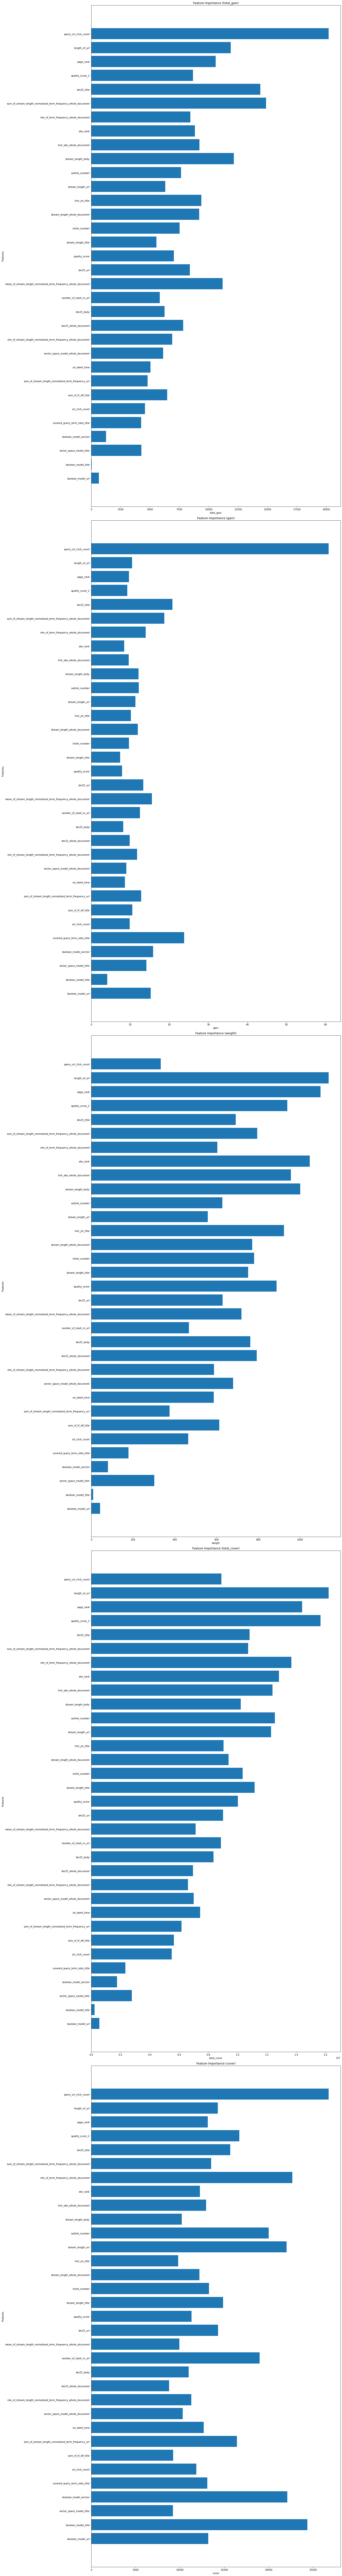

In [13]:
normed_sums2=showFeats(search2.best_estimator_)
print(cv_trainX.shape)

In [14]:
cv_valiX=dropcols(normed_sums,valiX,selected_feat)

results = predict_and_eval(search.best_estimator_,trainX,trainY,trainQid,'train_allfeats')

for pars in [[search2.best_estimator_,cv_trainX,trainY,trainQid,'train_reduced'],
               [search.best_estimator_,valiX,valiY,valiQid,'vali_allfeats'],
               [search2.best_estimator_,cv_valiX,valiY,valiQid,'vali_reduced']]:
    results=results.append(predict_and_eval(*pars),ignore_index=True)
display(results)

selected 31 features out of 136


,model_name,NDCG,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10
0,train_allfeats,0.914958,0.813918,0.815783,0.828895,0.838779,0.845894,0.850272,0.858466,0.862716,0.866443,0.869930
1,train_reduced,0.916979,0.818045,0.821605,0.833149,0.843462,0.849917,0.855063,0.862590,0.866822,0.870168,0.873488
2,vali_allfeats,0.760239,0.550075,0.535760,0.534402,0.533827,0.533647,0.534634,0.535487,0.536209,0.537857,0.538808
3,vali_reduced,0.760752,0.559506,0.542529,0.538602,0.534690,0.536930,0.537595,0.537796,0.538036,0.538848,0.541089


### 5) Evaluate model performance

In [15]:
ev_testX=dropcols(normed_sums,testX,selected_feat)
for pars in [(search.best_estimator_,testX,testY,testQid,'test_allfeats'),
               (search2.best_estimator_,ev_testX,testY,testQid,'test_reduced')]:
    results=results.append(predict_and_eval(*pars),ignore_index=True)
display(results)

selected 31 features out of 136


,model_name,NDCG,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10
0,train_allfeats,0.914958,0.813918,0.815783,0.828895,0.838779,0.845894,0.850272,0.858466,0.862716,0.866443,0.869930
1,train_reduced,0.916979,0.818045,0.821605,0.833149,0.843462,0.849917,0.855063,0.862590,0.866822,0.870168,0.873488
2,vali_allfeats,0.760239,0.550075,0.535760,0.534402,0.533827,0.533647,0.534634,0.535487,0.536209,0.537857,0.538808
3,vali_reduced,0.760752,0.559506,0.542529,0.538602,0.534690,0.536930,0.537595,0.537796,0.538036,0.538848,0.541089
4,test_allfeats,0.758926,0.549064,0.538511,0.532333,0.531388,0.531371,0.531928,0.534277,0.535049,0.536695,0.537019
5,test_reduced,0.756578,0.535231,0.530517,0.525721,0.525286,0.526493,0.528998,0.530201,0.530799,0.532097,0.532427


Evaluating the model is asked both here and in the discussion section, so we disuss in the latter instead of here.

# Discussion

### 6) Please answer the following questions about your choices:
- **Discuss your model and why you chose the model you chose (eg architecture, design, loss functions, etc)**

Learning to Rank (L2R) approaches tend to fall in three categories:
 * Pointwise - Optimize a score for each document and rankings are are in order by score.
 * Pairwise - Given two documents, optimize the margin between them.
 * Listwise - Given two ranked lists, optimize for the better list.

It appears as though most of the state-of-the-art (SoTA) models are currently pairwise. There is not a big enough benefit from moving to listwise approaches. If you sample enough points in the pairwise approaches and select the right metrics, your results approximate the listwise approaches and you have a benefit that you can over or undersample any point you like while solving a simpler problem. Pointwise approaches are just solving regression or classification problems, and not properly penalizing for getting an incorrect ordering.

With the success of neural networks on many problems, it is tempting to select a neural network approach (such as the linked [TF-Ranking](https://dl.acm.org/doi/pdf/10.1145/3292500.3330677) approach). Unfortunately, the sparseness of typical L2R problems on tabular data makes deep models prone to overfitting, a problem that showed up for [Burges et al.](https://proceedings.mlr.press/v14/burges11a/burges11a.pdf) in LambdaRANK. This is not to say that all deep models will have this problem. The features in this dataset are not well comparable between each other if they were embedded in the same space. As an example, the TF and IDF values are computed with respect to the query and interactions between the terms are lost. Comparing TF and IDF values across different rows doesn't make much sense because they are computed with respect to the query. Had word vectors been used instead, there would be more benefit to using a deep model. It is worth noting that the TF-Ranking approach used textual data so that it could leverage these benefits.

I elected to use `XGBRanker` from `XGBoost` which is a SoTA framework for boosted decision trees that is highly efficient. `XGBRanker` implements LambdaMART, a state of the art approach using bagged, boosted decision trees for tabular data. The efficiency of the model gives me a little time to tune hyperparameters.

LambdaMART propagates lambda estimates of how much gain the correct ordering has (or alternatively how much is lost if the ordering is not correct) back to training each decision tree. Using a smoothed loss metric like Normalized Discounted Cumulative Gain (NDCG) measures whether useful information was captured at different levels of the ranking and has a more minimal impact once the ratings are not near the top of the order. The normalization both makes convergence more consistent and makes interpretation easier.

- **Why did you choose your metric to evaluate the model?**

NDCG and Mean Average Precision (MAP) are the selected metrics by the authors of the dataset. This implies that most people using the dataset will provide results for these metrics. In order to be able to compare with other approaches, we should **at least** use one of the same comparison metrics. These metrics also show up in many other papers such as [Burges et al.](https://proceedings.mlr.press/v14/burges11a/burges11a.pdf). Burges found that there was little to no difference between NDCG and Expected Reciprocal Rank (ERR) (they varied by a similar amount over different models). Since NDCG is simpler than ERR, Burges suggests using the simpler NDCG.

Another argument for NDCG is that it is comparable. A score of `0.8` on one ranking can be directly compared to a score of `0.7`. The downside of NDCG is very similar to recall. The score remains high when irrelevant data is still ranked but not ranked first. To counter this, NDCG@N is used where @K refers to the top `K` ratings considered (`5` and `10` are popular). Looking at the NDCG@1-10 gives a good idea of whether it captures the most relevant document as well as whether it captures the trend as lists get longer.

- **How well would you say your model performed?**


In [16]:
display(results)

,model_name,NDCG,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10
0,train_allfeats,0.914958,0.813918,0.815783,0.828895,0.838779,0.845894,0.850272,0.858466,0.862716,0.866443,0.869930
1,train_reduced,0.916979,0.818045,0.821605,0.833149,0.843462,0.849917,0.855063,0.862590,0.866822,0.870168,0.873488
2,vali_allfeats,0.760239,0.550075,0.535760,0.534402,0.533827,0.533647,0.534634,0.535487,0.536209,0.537857,0.538808
3,vali_reduced,0.760752,0.559506,0.542529,0.538602,0.534690,0.536930,0.537595,0.537796,0.538036,0.538848,0.541089
4,test_allfeats,0.758926,0.549064,0.538511,0.532333,0.531388,0.531371,0.531928,0.534277,0.535049,0.536695,0.537019
5,test_reduced,0.756578,0.535231,0.530517,0.525721,0.525286,0.526493,0.528998,0.530201,0.530799,0.532097,0.532427


For the ranking problem, usually a small number of relevant documents are important. So we want to look at overall performance, but we really care more about how the top documents did than how all of the documents did. As we go further down the list of relevance, the documents become less likely that we want to suggest them anyways. So we focus on the overall NDCG and the first 10 NDCG@K values.

Our fit was not fantastic. We did not spend a lot of time tuning the hyperparameters. We could use an automated feature selection pipeline to do the selection, but we opted for a manual approach in order to demonstrate an understanding of the bias-variance tradeoff. As we reduced features from 136 to 40 to 30 to 15, there was not a large difference between the performance on the held-out validation set after tuning with 3-fold cross-validation  After reducing features, we got an increase in performance on our validation set versus our validation without reducing features.

Using 30 features gave us slightly better NDCG scores after feature selection. The difference in performance between our validation and training sets is still somewhat high, implying that we likely either overfit the model, the validation set was not very similar to the training set, or both. The fact that our model performed nearly the same with all of the features as it did with very few features suggests that we are underfitting. This is likely, because we did not have time to run as many parameter combinations as we would like.

We note that 3-fold cross-validation here is really one fold according to the MSLR-Web10K dataset. Unfortunately, it seems that if you use more than one fold in the dataset, you would be training on testing data because one fold is already cross-folded. In light of this, we find that our model is competitive with the models [from a student project](https://arxiv.org/pdf/1803.05127.pdf), where our model outperformed all of their models on a single fold. They had NDCG1 of `0.456` of their random forest versus our NDCG1 with the reduced feature set of `0.506`. Their NDCG10 was `0.435` while ours was `0.518`. Finding a better baseline seems a little difficult because current research has moved on from tabular data to text, a mix of text and tabular, or is performing online learning and multi-armed bandits instead of plain L2R.

- **If you had more time what else would you want to try?**

Given time restrictions and trying to keep everything in the notebook format, I have not worked on memory management for the dataset. Streaming the data so it does not all have to be loaded simultaneously would be beneficial. Using `PySpark` instead of `Pandas` would have let me stream the data better and would likely have had better performance.

I would have liked to do more exploratory data analysis. I could do either a repeated Principal Component Analysis, treating each group as a repetition. Exploratory Factor Analysis or Multiple Factor Analysis to get a description of which features were importanat. Multiple Factor Analysis would probably be the best choice because the datapoints are not technically independent. Then after learning my model, I could also do Confirmatory Factor Analysis.

Spending more time parameter tuning could yield a better model. I did not spend much time on this because this was more of a demonstration of the way to think than an actual optimization. It would have been better to tune multiple randomly selected models tuned over just cross-validation on the trainig set and then validating against the validation set. This would give us an unbiased measure that is likely to generalize to the testing set. This takes a lot of time and the effort put into it should be proportional to how important the model is to your work.

Comparing other approaches and how well they perform would give a much more insightful picture.

With this particular dataset, there really is not that much more I would like to try. Problematically, this dataset contains mostly summary statistics and removes the actual raw data. I would not blame the authors for this because there are potential privacy concerns. I do, however, believe that it limits the scope of usefulness of the data. Since my time is finite, I would rather spend my time on a dataset that includes the actual textual data.

### 7) Please answer the following questions about how you would use additional features:

- **If you had an additional feature for each row of the dataset that was unique identifier for the user performing the query e.g. `user_id`, how could you use it to improve the performance of the model?**

An additional row for the user translates this from a L2R problem to a User Modeling or Recommender Systems problem instead of an Information Retrieval problem. The reality is that users do not all rank things the same because they have different preferences, decision making styles, and different reasons for searching (tasks). The general idea behind user modeling is that users that rank things similarly have some of the aforementioned properties in common. Leveraging those properties enables one to make recommendations that are better suited to each individual in a technique called Collaborative Filtering (CF).

A great approach to to solve this problem would be Weighted Matrix Factorization (WMF). Solving a WMF problem with Stochastic Gradient Descent (SGD) would likely yield pretty good results. This dataset would still suffer, however, because the features themselves are not selected to perform well. As I described in Section 6, bullet 1, the interactions between the features are not as useful as the raw data would be.

- **If you had the additional features of: `query_text` or the actual textual query itself, as well as document text features like `title_text`, `body_text`, `anchor_text`, `url` for the document, how would you include them in your model (or any model) to improve its performance?**

It is not clear to me whether this question is implying that we are also using the `user_id` from the previous bullet. If we are using `user_id` then I would recast the problem as one of Matrix Completion. The idea is that the number of rankings from each individual is typically very small compared to the number items to rank. So mapping items and user preferences to an embedding space where relationships between them can be explored enables one to generate ratings for unseen content. In this embedding space we can predict intermediate values. Then we can use Collaborative Filtering to predict rankings. I would be interested in solving Matrix Completion with a Transformer and then using Stochastic Gradient Descent to solve WMF. The beauty of this approach is that we can give completed items in the matrix lower weights and tune to boost performance by leveraging intermediate values.

If we are leaving `user_id` out and just using the text, then we could solve it as a L2R problem, but to take advantage of the text, a deep network (or at least an embedding model) would be more appropriate. The TF-Ranking approach suggested at the beginning of the document would then be a good fit. We could also treat it as a classic content-based filtering in the Recommender Systems world. We might use a Transformer with `Q=query_text`, `K=title_text`, and `V=body_text`. Then the output from the Encoder would be a feature representation space. We could concatenate features that we already have. Then we could solve the same Learning to Rank problem over the new features with the LambdaMART approach we used in this document.